# CNN Model Training


- Alexnet Model Architecture: Accepts 256 * 256 pixel images with 3 channels

## Importing Required Libraries

In [51]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from importlib import reload
import pickle
from sklearn.metrics import accuracy_score
from skorch.helper import predefined_split

In [52]:
def readPickleFile(path, file):
  opath = path+file
  data = None
  with open(opath, "rb") as file:
    data = pickle.load(file)
  return data

In [53]:
# custom dataset class. 
class MaskDataSet(Dataset):
  def __init__(self, data, label, transform=None, target_transform=None):
    super(Dataset, self).__init__()
    self.data = data
    self.label = label
    self.transform = transform
    self.target_transform = target_transform
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    img = self.data[index]
    if(self.transform):
      img = self.transform(img)
      
    label = self.label[index]
    if(self.target_transform):
      label = self.target_transform(label)
    return img, label


## Visualising the Dataset



In [234]:
import pandas as pd
plt=reload(plt)

def displayDistribution(y, title):
  
  df = pd.DataFrame(y, columns=["labels"])
  cloth_based = df[df["labels"] == 1].shape[0]
  surgical_mask = df[df["labels"] == 2].shape[0]
  no_mask = df[df["labels"] == 3].shape[0]
  valve_mask = df[df["labels"] == 4].shape[0]
  no_valve = df[df["labels"] == 5].shape[0]

  plt.title(title)
  plt.rcParams["figure.figsize"] = (10, 5)
  plt.bar("cloth", cloth_based)
  plt.bar("surgical", surgical_mask)
  plt.bar("no mask", no_mask)
  plt.bar("valve mask", valve_mask)
  plt.bar("no valve", no_valve)
  plt.plot()

## AlexNet Model Architecture

In [239]:
from torch.utils.data import DataLoader


test_data = readPickleFile("", "train_256.pkl")
data = readPickleFile("", "test_256.pkl")
(X, y) = data

(X_test, y_test) = test_data


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.5598, 0.5210, 0.4990], [0.3023, 0.2992, 0.3075])
])
mask_dataset = MaskDataSet(X, y, transform=img_transform)
mask_test_dataset = MaskDataSet(X_test, y_test, transform=img_transform)

y_cloth_train = []
for k, m in iter(mask_dataset):
  y_cloth_train.append(m)

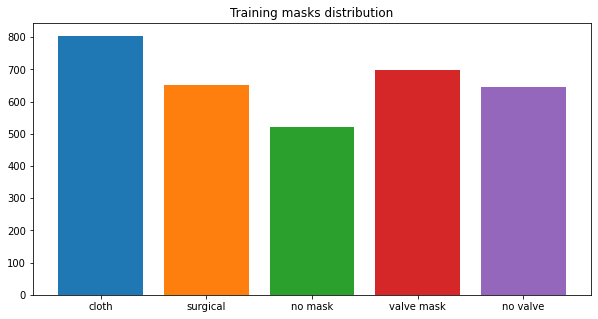

In [240]:
displayDistribution(y, "Training masks distribution")

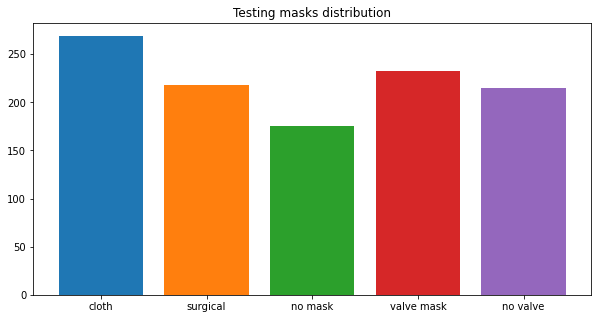

In [241]:
displayDistribution(y_test, "Testing masks distribution")

# AlexNet Training

<img src="./alexnet.png" alt="drawing" width="1300"/>

Photo Credits: https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

Ref Used (Important): 

1.   https://en.wikipedia.org/wiki/AlexNet
2.   https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96
3. Other sources are mentioned below in the ref section




In [242]:

class AlexNetwork(nn.Module):
  def __init__(self):
    super(AlexNetwork, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0)
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
  
    self.linear1  = nn.Linear(in_features= 9216, out_features= 4096)
    self.linear2  = nn.Linear(in_features= 4096, out_features= 4096)
    self.linear3 = nn.Linear(in_features=4096 , out_features=10)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    output = self.conv1(x)
    output = self.relu(output)
    # max pooling
    output = self.maxpool(output)
    # second conv layer.
    output = self.conv2(output)
    output = self.relu(output)

    # third convolutional layer
    output = self.conv3(output)
    output = self.relu(output)

    # fourth convolutional layer
    output = self.conv4(output)
    output = self.relu(output)

    # fifth convolutional layer
    output = self.conv5(output)
    output = self.relu(output)

    # Maxpooling layer. 
    output = self.maxpool(output)

    # Flattening layer followed by the fc network
    output = output.reshape(output.shape[0], -1)
    output = self.linear1(output)
    output = self.relu(output)

    output = self.linear2(output)
    output = self.relu(output)    

    output = self.linear3(output)
    return output

In [243]:
torch.manual_seed(0)
training_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def trainModel(optimizer, epochs=training_epochs):
    network = NeuralNetClassifier(
        module=AlexNetwork,
        max_epochs=epochs,
        train_split= predefined_split(mask_dataset),
        optimizer=optimizer,
        device=device,
        criterion=nn.CrossEntropyLoss,
        lr=1e-4,
        batch_size=128,
         callbacks=[
            EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
        ],
    )
    network.fit(mask_dataset, None)
    return network

In [244]:
def metricsGenerator(network, training_epochs, train_loss, train_acc, valid_loss, valid_acc):
    net = network
    for i in range(training_epochs):
        train_loss.append(net.history[i]['train_loss'])
        valid_loss.append(net.history[i]['valid_loss'])
        valid_acc.append(net.history[i]['valid_acc'])
        train_acc.append(net.history[i]['train_acc'])


## Training the Model for Larger Epochs

In [245]:
rfromCache = input("Do you want to read model from cache Y/N: ")

net = None
if(rfromCache == "Y" or rfromCache == "y"):
    with open("./alexnet.pkl", "rb") as modelFile:
        net = pickle.load(modelFile)
else:
        net = trainModel(torch.optim.Adam)

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.2178        3.6670       0.2100        2.2740  7.0238
      2       0.0476        2.2543       0.2100        2.0939  6.9079
      3       0.0880        2.0732       0.1964        2.0493  7.0458
      4       0.1964        1.9692       0.2100        1.8342  6.7241
      5       0.2100        1.8901       0.2100        1.7898  6.6792
      6       0.2100        1.8556       0.2100        1.6350  6.6722
      7       0.0000        1.8231       0.2422        1.6847  6.6572
      8       0.2422        1.7161       0.2422        1.6308  6.5383
      9       0.2422        1.6645       0.2422        1.6187  6.4404
     10       0.2422        1.6730       0.2422        1.6152  6.4904
     11       0.2061        1.6704       0.2422        1.6148  6.4434
     12       0.2422        1.6677       0.2422        1.6138  6.4794
     13       0.2422

In [246]:
# since training the Alex net model is an expensive operation, we saved it in the pickle file.
with open("alexnet.pkl", "wb") as file:
    pickle.dump(net, file)
print("Saved Alex Network trained on 200 epochs")

Saved Alex Network trained on 200 epochs


In [247]:
train_loss=[]
train_acc = []
valid_loss = []
valid_acc = []
epochs = 200
metricsGenerator(net, epochs, train_loss, train_acc, valid_loss, valid_acc)

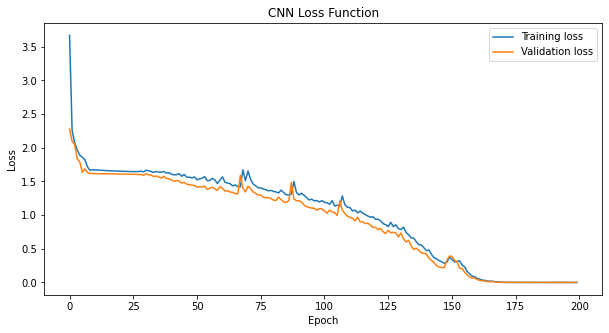

In [248]:
plt.title("CNN Loss Function")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss,  '-', label="Training loss")
plt.plot(valid_loss, '-', label="Validation loss")
plt.legend()
plt.show()

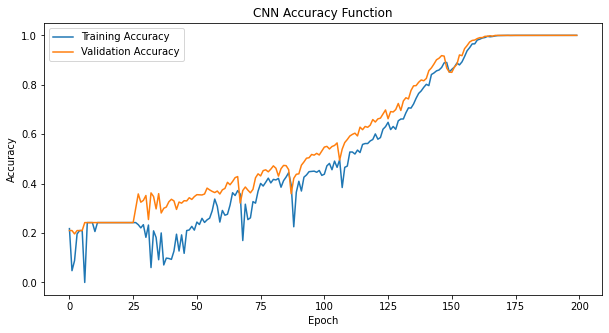

In [249]:
plt.title("CNN Accuracy Function")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc, '-', label="Training Accuracy")
plt.plot(valid_acc, '-', label="Validation Accuracy")
plt.legend()
plt.show()

In [253]:
y_pred = net.predict(mask_test_dataset)
y_test = []
for x, y in iter(mask_test_dataset):
  y_test.append(y)

y_test = np.array(y_test)
r = accuracy_score(y_test, y_pred)
accuracy = r * 100
print("Model accuracy is {} %".format(accuracy))

Model accuracy is 61.8018018018018 %


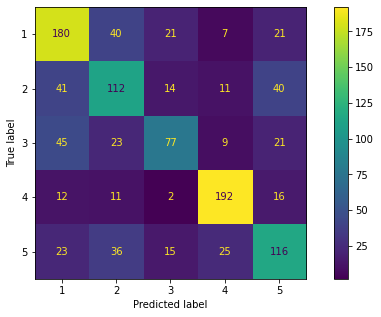

In [254]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(net, mask_test_dataset, y_test.reshape(-1, 1))
plt.show()

In [255]:
from sklearn.metrics import classification_report
target_names = ['Cloth Mask', 'Surgical', 'No Mask','Valve','Without Valve']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

   Cloth Mask       0.63      0.67      0.65       269
     Surgical       0.54      0.55      0.54       218
      No Mask       0.57      0.45      0.50       175
        Valve       0.76      0.82      0.79       233
Without Valve       0.55      0.55      0.55       215

     accuracy                           0.62      1110
    macro avg       0.61      0.61      0.61      1110
 weighted avg       0.61      0.62      0.61      1110



## References
1.   https://towardsdatascience.com/basics-of-the-classic-cnn-a3dce1225add
2.   https://en.wikipedia.org/wiki/LeNet#:~:text=In%20general%2C%20LeNet%20refers%20to,in%20large%2Dscale%20image%20processing.
3. https://matplotlib.org/stable/tutorials/introductory/pyplot.html
4. https://medium.datadriveninvestor.com/train-a-cnn-using-skorch-for-mnist-digit-recognition-53d7d2f971c7
5. https://stackoverflow.com/questions/19125722/adding-a-legend-to-pyplot-in-matplotlib-in-the-simplest-manner-possible
6. https://github.com/skorch-dev/skorch
7. https://skorch.readthedocs.io/en/stable/user/save_load.html
8. https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
9. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
10. https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
11. https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96
